# Development of a Reader for Siemens Trend CSV files

This notebook was used for development of the final Siemens reader.  The code was then exported out
out of here and put into the `ddc_readers.py` module.

In [1]:
import csv
import string
import datetime
import pandas as pd
import numpy as np

# import matplotlib pyplot commands
from matplotlib.pyplot import *
 
# Show Plots in the Notebook
%matplotlib inline
 
rcParams['figure.figsize']= (10, 8)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

# 'style' the plot using 'bmh' style
style.use('bmh')


### Use this function to clean up point names and location names

In [2]:
def clean_string(s):
    """Function that "cleans" a string by first stripping leading and trailing
    whitespace and then substituting an underscore for all other whitepace
    and punctuation. After that substitution is made, any consecutive occurrences
    of the underscore character are reduced to one occurrence. 
    Finally, the string is converted to lower case.
    Returns the cleaned string.

    Input Parameters:
    -----------------
    s:  The string to clean.
    """
    to_sub = string.whitespace + string.punctuation
    trans_table = str.maketrans(to_sub, len(to_sub) * '_')
    fixed = str.translate(s.strip(), trans_table)

    while True:
        new_fixed = fixed.replace('_' * 2, '_')
        if new_fixed == fixed:
            break
        fixed = new_fixed

    return fixed.lower()


### Use the Python csv module to read the file

In [3]:
file_name = 'data/siemens_sample.csv'
reader = csv.reader(open(file_name))
include_location = False   # if True include location in point ID

# For running in the notebook, this controls how many rows are shown
# for each execution of the cell below.
# Set to a very large number if you want to process the entire file
# in one execution of the cell below.
num_rows_to_show = 300000

# Going to put the data into a dictionary, keyed by the name of the
# point
data_dict = {}

In [4]:
# repeatedly execute this cell to step through chunks of the data
row_ct = 0
for row in reader:
    
    f1 = row[0]    # the first field
    
    if '/' in f1:     # Look for the / in the Date
        # this is a row with a data point in it.
        # create a date/time string and parse into a Python datetime
        ts = '{} {}'.format(row[0], row[1])
        ts = datetime.datetime.strptime(ts, '%m/%d/%Y %H:%M:%S')
        
        # get the value, which is usually a number, but sometimes a string.
        # first try to convert to a number, and if it errors, just return it as a string
        try:
            val = float(row[2])
        except:
            val = row[2]
            
        tstamps, vals = data_dict.get(pt_id, ([], []))
        tstamps.append(ts)
        vals.append(val)
        data_dict[pt_id] = (tstamps, vals)
        
    elif f1.startswith('Point'):
        # This row has a Point ID in it
        pt_id = clean_string(row[1])

    elif f1.startswith('Trend L'):
        # This row has a Location code in it.  If requested, add it
        # to the point name.
        if include_location:
            pt_id = '{}_{}'.format(clean_string(row[1]), pt_id)
    
    row_ct += 1
    if row_ct == num_rows_to_show: break


### Create the Final DataFrame by concatenating a DataFrame for each Point

In [5]:
df_final = pd.DataFrame()
for pt_id in data_dict.keys():
    
    # for this point, retrieve the timestamps and values frome the dictionary
    tstamps, vals = data_dict[pt_id]
    
    # make a DataFrame, indexed on the timestamps, with the point ID as the column
    # name.
    df = pd.DataFrame(vals, index=tstamps, columns=[pt_id])
    
    # Sometimes there are duplicate timestamps due to Alarms, I think.
    # Only take the value from the last timestamp of the duplicate timestamps.
    df = df.groupby(level=0).last()
    
    # Add this DataFrame to the final DataFrame.  Indexes are matched up
    # or added if they don't already exist in the final frame.
    df_final = pd.concat([df_final, df], axis=1)


In [6]:
# Save the final DataFrame to a CSV file to be viewed, perhaps by Excel.
df_final.to_csv('df_final.csv')

### Plot a couple points, getting rid of gaps by using `drop_na()`

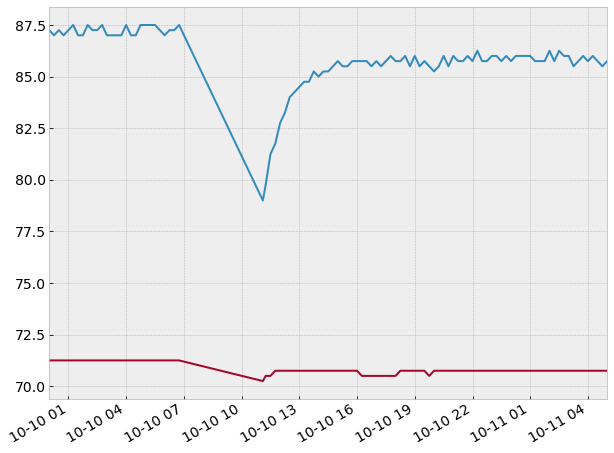

In [7]:
df_final.bh_100w_tec_room_temp.dropna().plot()
df_final.bh_uhe_tec_room_temp.dropna().plot()

### Export this Code to a File

In [8]:
# Convert the notebook to a script.
# I usually have this commented out
# !jupyter nbconvert --to script siemens_reader.ipynb